# import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import warnings 
warnings.filterwarnings("ignore")
import time

# DATA PREPARATION
## Load the training data and test data

In [4]:
column_name = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
               's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
               's15', 's16', 's17', 's18', 's19', 's20', 's21']
train_FD001 = pd.read_table("./CMAPSSData/train_FD002.txt", header=None, delim_whitespace=True)
train_FD001.columns = column_name
# Test 文件中的cycle数 并不是到死的
test_FD001 = pd.read_table("./CMAPSSData/test_FD002.txt", header=None, delim_whitespace=True)
test_FD001.columns = column_name

# load RUL data 真正的最后循环数存放在这里
RUL_FD001 = pd.read_table("./CMAPSSData/RUL_FD002.txt", header=None, delim_whitespace=True)

In [5]:
train_FD001.head()

,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


# Feature extention

## Difference with previous row

In [6]:
train_FD001 = train_FD001.drop(['s1','setting1','setting2','setting3','s5','s6','s10','s16','s18','s19'],axis = 1)

In [7]:
test_FD001 = test_FD001.drop(['s1','setting1','setting2','setting3','s5','s6','s10','s16','s18','s19'],axis = 1)

In [8]:
# _id =1
# s2_diff = []
# s2_diff_temp = []
# diff_periods = 40
# for _id in set(train_FD001[id]):
#     trainFD001_of_one_id =  train_FD001[train_FD001[id] == _id]
#     s2 = pd.Series(trainFD001_of_one_id['s2'])
#     for i in range(diff_periods):
#         s2_diff.append(s2.iloc[i]-s2.iloc[0])
#     s2_diff_temp=s2.diff(periods=diff_periods)
#     for j in range (len(s2)-diff_periods):
#         s2_diff.append(s2_diff_temp.iloc[diff_periods])


In [9]:
def cal_diff(df, sensor_name,diff_periods = 40):
    _id =1
    sensor_diff = []
    sensor_diff_temp = []
    for _id in set(df['engine_id']):
        trainFD001_of_one_id =  df[df['engine_id'] == _id]
        s = pd.Series(trainFD001_of_one_id[sensor_name])
        #判断每一个数列的长度是否大于diff_periods
        if len(s)>diff_periods:
            sensor_diff_temp=s.diff(periods=diff_periods)
            # 第0到39 应该是每一个值-第一个值
            for i in range(diff_periods):
                sensor_diff.append(s.iloc[i]-s.iloc[0])
            # 第40个值之后应该是每一个值-向前推40位的值
            for j in range (len(s)-diff_periods):
                sensor_diff.append(sensor_diff_temp.iloc[diff_periods+j])
        else:
            for h in range(len(s)):
                sensor_diff.append(s.iloc[h]-s.iloc[0])
    return sensor_diff

In [10]:
#from Feature_extention import cal_diff

In [11]:
#get all the names of sensors
list(train_FD001.columns)
sensor_name = list(train_FD001.columns)
sensor_name = sensor_name[2:16]
sensor_name

['s2',
 's3',
 's4',
 's7',
 's8',
 's9',
 's11',
 's12',
 's13',
 's14',
 's15',
 's17',
 's20',
 's21']

In [12]:
for i in range(len(sensor_name)):
    sensor_name_temp = sensor_name[i]
    diff = cal_diff(train_FD001,sensor_name=sensor_name_temp) 
    name = sensor_name_temp+'_diff'
    train_FD001[name] = diff

In [13]:
for i in range(len(sensor_name)):
    sensor_name_temp = sensor_name[i]
    diff = cal_diff(test_FD001,sensor_name=sensor_name_temp) 
    name = sensor_name_temp+'_diff'
    test_FD001[name] = diff

In [14]:
test_FD001

,engine_id,cycle,s2,s3,s4,s7,s8,s9,s11,s12,...,s8_diff,s9_diff,s11_diff,s12_diff,s13_diff,s14_diff,s15_diff,s17_diff,s20_diff,s21_diff
0,1,1,605.03,1497.17,1304.99,394.54,2318.96,8763.80,45.61,371.69,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0,0.00,0.0000
1,1,2,607.82,1481.20,1246.11,334.36,2323.95,8713.21,44.26,315.32,...,4.99,-50.59,-1.35,-56.37,-0.06,-61.04,0.5929,-5.0,-4.13,-2.3512
2,1,3,556.00,1359.08,1128.36,193.55,2222.67,8340.20,41.80,183.04,...,-96.29,-423.60,-3.81,-188.65,-0.43,-61.06,0.6996,-36.0,-13.44,-8.2426
3,1,4,550.17,1349.69,1127.89,138.74,2211.58,8313.85,42.21,130.40,...,-107.38,-449.95,-3.40,-241.29,-0.46,-47.20,0.7485,-37.0,-18.07,-10.7370
4,1,5,536.72,1253.18,1050.69,175.75,1915.10,7997.13,36.76,164.56,...,-403.86,-766.67,-8.85,-207.13,-360.13,-248.44,2.2206,-64.0,-14.11,-8.5811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33986,259,119,555.56,1366.01,1129.47,194.87,2223.24,8367.35,41.96,183.05,...,11.25,48.61,-0.11,51.91,0.37,3.18,0.0006,4.0,4.23,2.4774
33987,259,120,549.42,1351.13,1123.86,138.34,2212.19,8339.94,42.00,130.74,...,0.21,13.06,0.01,-0.17,0.31,18.76,0.0162,1.0,-0.02,0.0049
33988,259,121,549.65,1349.14,1118.91,138.27,2212.29,8341.70,42.15,130.96,...,0.37,17.19,0.04,0.06,0.27,11.26,0.0464,2.0,-0.10,0.1074
33989,259,122,642.58,1589.61,1408.16,553.13,2388.05,9077.35,47.47,522.25,...,64.07,347.45,3.22,207.13,-0.11,93.68,-0.7982,29.0,14.29,8.7155


In [15]:
train_FD001.describe()

,engine_id,cycle,s2,s3,s4,s7,s8,s9,s11,s12,...,s8_diff,s9_diff,s11_diff,s12_diff,s13_diff,s14_diff,s15_diff,s17_diff,s20_diff,s21_diff
count,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,...,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000
mean,131.082981,109.154746,579.672399,1419.971013,1205.442024,282.606787,2228.879188,8525.200837,42.985172,266.069034,...,3.081285,8.952441,0.156009,0.797003,2.895800,4.284143,0.001469,0.890288,0.028807,0.018103
std,74.463862,69.180569,37.289399,105.946341,119.123428,146.005306,145.209816,335.812013,3.232372,137.659507,...,206.625560,476.341190,4.582352,195.515665,182.459179,119.010669,1.064877,39.378834,14.022907,8.413905
min,1.000000,1.000000,535.530000,1243.730000,1023.770000,136.800000,1914.770000,7985.560000,36.230000,129.120000,...,-473.390000,-1065.350000,-11.080000,-392.650000,-360.520000,-280.570000,-2.541900,-89.000000,-28.790000,-17.238300
25%,68.000000,52.000000,549.570000,1352.760000,1123.655000,139.935000,2211.880000,8321.660000,41.910000,131.520000,...,-106.770000,-342.005000,-3.030000,-150.250000,-0.100000,-47.490000,-0.672450,-28.000000,-10.250000,-6.151100
50%,131.000000,104.000000,555.980000,1369.180000,1138.890000,194.660000,2223.070000,8361.200000,42.390000,183.200000,...,0.020000,2.540000,0.100000,-0.080000,0.030000,1.640000,0.011500,0.000000,-0.020000,-0.010700
75%,195.000000,157.000000,607.340000,1499.370000,1306.850000,394.080000,2323.960000,8778.030000,45.350000,371.260000,...,107.040000,368.770000,3.310000,150.060000,0.200000,53.010000,0.689300,30.000000,10.200000,6.122100
max,260.000000,378.000000,644.520000,1612.880000,1439.230000,555.820000,2388.390000,9215.660000,48.510000,523.370000,...,473.210000,1172.030000,11.530000,392.870000,361.540000,358.310000,2.613100,92.000000,28.790000,17.305000


## standard normalization 

In [16]:
#### standard normalization ####

# Training 因为前两列是没有用的 engine_id cycle
mean = train_FD001.iloc[:, 2:].mean()
std = train_FD001.iloc[:, 2:].std()
std.replace(0, 1, inplace=True)
train_FD001.iloc[:, 2:] = (train_FD001.iloc[:, 2:] - mean) / std

# Testing
test_FD001.iloc[:, 2:] = (test_FD001.iloc[:, 2:] - mean) / std

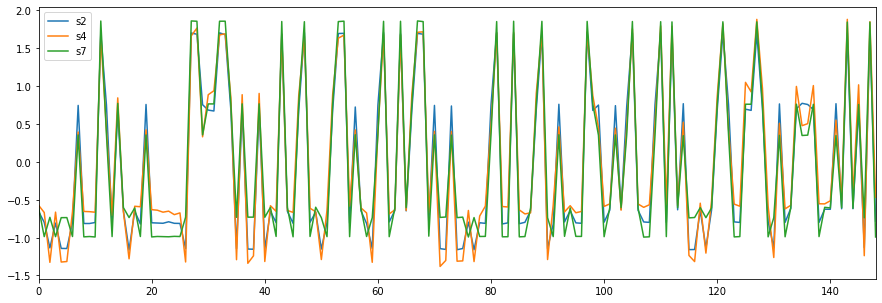

In [17]:
train_FD001[train_FD001["engine_id"]==1][["s2","s4","s7"]].plot(figsize=(15,5));

## Compute the RUL

### Training 

In [18]:
id='engine_id'
# 这个是自己定义的， 拐点在120 ，  120之前视为一样
MAXLIFE = 125
rul = [] # 会逐渐装满所有id的RUL
for _id in set(train_FD001[id]):
    trainFD001_of_one_id =  train_FD001[train_FD001[id] == _id]
    cycle_list = trainFD001_of_one_id['cycle'].tolist()
    # 因为这里是run to end ,所以最大cycle数是确定的
    max_cycle = max(cycle_list)
    # 计算出临界点的位置，没到达临界点的时候，全部保存MAXLIFE，到达临界点的时候，逐点下降！
    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    for i in range(0, len(cycle_list)):
        # 
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = kink_RUL[i - 1] - 1
            kink_RUL.append(tmp)
    # 每跑完一个id就添加到最后总的rul列表中
    rul.extend(kink_RUL)

train_FD001["RUL"] = rul


### Testing

In [19]:
id='engine_id'
rul = []
for _id_test in set(test_FD001[id]):
    # 真实的RUL， 也就是测试数据最后一个周期所对应的RUL
    true_rul = int(RUL_FD001.iloc[_id_test - 1])
    testFD001_of_one_id =  test_FD001[test_FD001[id] == _id_test]
    cycle_list = testFD001_of_one_id['cycle'].tolist()
    # 那么总的生命周期数=训练集的已有周期数+最后剩下的周期数
    max_cycle = max(cycle_list) + true_rul
    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    for i in range(0, len(cycle_list)):
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = kink_RUL[i - 1] - 1
            kink_RUL.append(tmp)    

    rul.extend(kink_RUL)

test_FD001["RUL"] = rul

In [20]:
min_shape = np.min([i[0] for i in train_FD001.groupby("engine_id").apply(np.shape).values])
print("训练集中最小的长度是：",min_shape)

训练集中最小的长度是： 128


In [21]:
min_shape = np.min([i[0] for i in test_FD001.groupby("engine_id").apply(np.shape).values])
print("测试集中最小的长度是：",min_shape)

测试集中最小的长度是： 21


In [22]:
train_FD001[train_FD001["engine_id"]==1].head()

,engine_id,cycle,s2,s3,s4,s7,s8,s9,s11,s12,...,s9_diff,s11_diff,s12_diff,s13_diff,s14_diff,s15_diff,s17_diff,s20_diff,s21_diff,RUL
0,1,1,-0.653065,-0.579171,-0.572616,-0.602490,-0.042898,-0.545814,-0.298596,-0.603003,...,-0.018794,-0.034046,-0.004076,-0.015871,-0.035998,-0.001380,-0.022608,-0.002054,-0.002152,125
1,1,2,-0.798415,-0.630045,-0.668735,-0.986928,-0.119201,-0.658823,-0.242909,-0.985395,...,-0.098464,0.005235,-0.273313,-0.016200,0.163480,0.028013,-0.124186,-0.310122,-0.304104,125
2,1,3,-1.136044,-1.540506,-1.326288,-0.732143,-2.160799,-1.559744,-1.947540,-0.739862,...,-0.733597,-1.197204,-0.100437,-1.987216,-1.579473,1.452309,-0.657467,-0.048407,-0.018173,125
3,1,4,-0.808873,-0.622400,-0.663698,-0.987271,-0.119132,-0.658823,-0.317158,-0.983216,...,-0.098464,-0.047139,-0.271779,-0.016474,0.132894,0.004912,-0.149580,-0.297285,-0.279906,125
4,1,5,-1.142480,-1.531540,-1.322259,-0.736664,-2.160868,-1.584133,-1.885665,-0.739208,...,-0.750791,-1.153558,-0.099977,-1.987380,-1.610059,1.454375,-0.657467,-0.044841,-0.035251,125


### 去掉不变的sensor的值和setting

In [23]:
train_FD001

,engine_id,cycle,s2,s3,s4,s7,s8,s9,s11,s12,...,s9_diff,s11_diff,s12_diff,s13_diff,s14_diff,s15_diff,s17_diff,s20_diff,s21_diff,RUL
0,1,1,-0.653065,-0.579171,-0.572616,-0.602490,-0.042898,-0.545814,-0.298596,-0.603003,...,-0.018794,-0.034046,-0.004076,-0.015871,-0.035998,-0.001380,-0.022608,-0.002054,-0.002152,125
1,1,2,-0.798415,-0.630045,-0.668735,-0.986928,-0.119201,-0.658823,-0.242909,-0.985395,...,-0.098464,0.005235,-0.273313,-0.016200,0.163480,0.028013,-0.124186,-0.310122,-0.304104,125
2,1,3,-1.136044,-1.540506,-1.326288,-0.732143,-2.160799,-1.559744,-1.947540,-0.739862,...,-0.733597,-1.197204,-0.100437,-1.987216,-1.579473,1.452309,-0.657467,-0.048407,-0.018173,125
3,1,4,-0.808873,-0.622400,-0.663698,-0.987271,-0.119132,-0.658823,-0.317158,-0.983216,...,-0.098464,-0.047139,-0.271779,-0.016474,0.132894,0.004912,-0.149580,-0.297285,-0.279906,125
4,1,5,-1.142480,-1.531540,-1.322259,-0.736664,-2.160868,-1.584133,-1.885665,-0.739208,...,-0.750791,-1.153558,-0.099977,-1.987380,-1.610059,1.454375,-0.657467,-0.044841,-0.035251,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,0.780855,0.713842,0.537829,0.351996,0.661393,0.973965,0.536704,0.348548,...,0.008413,-0.263186,-0.297148,-0.011377,-0.210184,0.587796,-0.073397,-0.295146,-0.317154,4
53755,260,313,0.700939,0.890536,0.996261,0.752392,0.621796,1.163327,0.957448,0.763848,...,1.782142,1.995480,1.052054,1.952953,2.697202,-2.030159,1.678813,0.985615,1.001140,3
53756,260,314,-1.131485,-1.356640,-1.238396,-0.736253,-2.145235,-1.223514,-1.808323,-0.743349,...,0.080546,-0.001311,-0.007350,-0.009952,0.395560,0.105581,0.002786,-0.004907,-0.010982,2
53757,260,315,-1.121831,-1.387693,-1.168049,-0.738307,-2.145304,-1.228577,-1.752636,-0.738772,...,-1.574801,-1.851890,-1.061690,-1.977515,-1.817267,2.200377,-1.571664,-1.036077,-1.040540,1


### plot a figure

training (53759, 28) (53759,)
testing (33991, 28) (33991,)


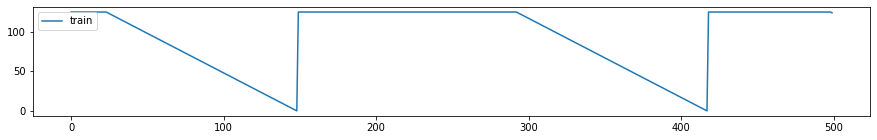

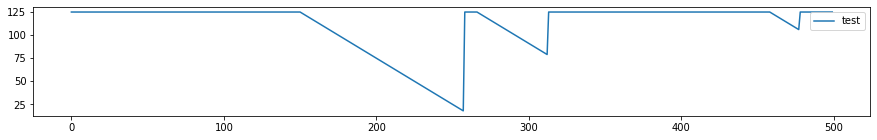

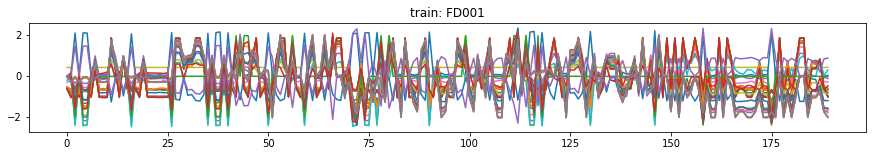

In [24]:
training_data = train_FD001.values
testing_data = test_FD001.values

x_train = training_data[:, 2:-1]
y_train = training_data[:, -1]
print("training", x_train.shape, y_train.shape)

x_test = testing_data[:, 2:-1]
y_test = testing_data[:, -1]
print("testing", x_test.shape, y_test.shape)
# 训练数据集 前面500个数据点所对应的rul 由图中可以看出  都是到零的了
plt.figure(figsize=(15,2))
plt.plot(y_train[:500], label="train")
plt.legend()
plt.figure(figsize=(15,2))
# 测试数据中前500个数据点对应的tul  可以看到结尾数据的rul 都不是中间
plt.plot(y_test[:500], label="test")
plt.legend()
plt.figure(figsize=(15,2))
plt.plot(x_train[:190])
plt.title("train: FD00" + str(1))
# 训练数据第一个id的 24个senor的值 可以通过在x轴坐标100的位置 序列的一些 趋势

plt.show()

In [25]:
def batch_generator(training_data, sequence_length=15, window_size = 15):
    """
    Generator function for creating random batches of training-data for many to many models
    """
    engine_ids = list(training_data["engine_id"].unique())
    temp = training_data.copy()
    # 把 每一段后一截给截掉，获取能够跑的index
    for id_ in engine_ids:
        indexes = temp[temp["engine_id"] == id_].index
        traj_data = temp.loc[indexes]
        # cutoff_cycle 记录下这以后的index就不满足 序列大小的需求的
        cutoff_cycle = max(traj_data['cycle']) - sequence_length - window_size + 1
        
        if cutoff_cycle<0:
            # 也就是步长和窗口大小已经大于了该机器的已有周期数，全部都得扔掉
            drop_range = indexes
            print("有一些数据直接就被抛弃了，请合理设置窗口大小和时间长度")
        else:
            cutoff_cycle_index = traj_data['cycle'][traj_data['cycle'] == cutoff_cycle+2].index
            drop_range = list(range(cutoff_cycle_index[0], indexes[-1] + 1))
            
        temp.drop(drop_range, inplace=True)
    indexes = temp.index
    del temp
    

    x_shape = (len(indexes), sequence_length, window_size, 28)
    x_batch = np.zeros(shape=x_shape, dtype=np.float32)
    y_shape = (len(indexes), sequence_length)
    y_batch = np.zeros(shape=y_shape, dtype=np.float32)
    
    # 第一个数据集
    alt_index = indexes[0]
    for batch_index, index in enumerate(indexes):
        # 因为对齐的原因，都减去了1
        y_batch[batch_index] = training_data.iloc[index+window_size-1:index+window_size-1+sequence_length,-1].values
        
        # 本来应该下面这个 for 循环的，但是考虑到循环的嵌套，跑太久了，而且窗口序列之间又有重复，那么减少循环的次数
        # for seq in range(sequence_length):
            # x_batch[index,seq] = training_data.iloc[idx+seq:idx+seq + window_size, 2:-1].values
        
        if index-alt_index==1 and batch_index!=0:
            temp_window = training_data.iloc[index+sequence_length-1:index+sequence_length-1 + window_size, 2:-1].values.reshape(1,window_size,-1)
            x_batch[batch_index] = np.concatenate((x_batch[batch_index-1][1:],temp_window))
        else:
            for seq in range(sequence_length):
                x_batch[batch_index][seq] = training_data.iloc[index+seq:index+seq + window_size, 2:-1].values
        alt_index = index
    # 如果数据集过于大的情况下 应该使用yield来构成 循环的 generator、
    
    return x_batch, y_batch

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
#from tensorflow.keras.layers.convolutional import Conv3D
#from tensorflow.keras.layers.convolutional_recurrent import ConvLSTM2D
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

In [27]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from tensorflow.python.keras import activations
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.layers.recurrent import DropoutRNNCellMixin
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.util.tf_export import keras_export
from tensorflow.compat.v2.keras.layers import ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
#from tensorflow.keras.layers.convolutional import Conv3D
#from tensorflow.keras.layers.convolutional_recurrent import ConvLSTM2D
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.python.keras.layers.recurrent import RNN
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.layers.recurrent import _standardize_args
from tensorflow.python.keras.utils import generic_utils


In [28]:
sequence_length=5
window_size = 24
kernel_size = 3

In [29]:
x_batch, y_batch =batch_generator(train_FD001,sequence_length=sequence_length,window_size = window_size)
# 这里需要把输入数据增加一个channel层数
x_batch = np.expand_dims(x_batch, axis=4)
y_batch = np.expand_dims(y_batch, axis=2)

In [30]:
y_batch

array([[[125.],
        [124.],
        [123.],
        [122.],
        [121.]],

       [[124.],
        [123.],
        [122.],
        [121.],
        [120.]],

       [[123.],
        [122.],
        [121.],
        [120.],
        [119.]],

       ...,

       [[  6.],
        [  5.],
        [  4.],
        [  3.],
        [  2.]],

       [[  5.],
        [  4.],
        [  3.],
        [  2.],
        [  1.]],

       [[  4.],
        [  3.],
        [  2.],
        [  1.],
        [  0.]]], dtype=float32)

In [31]:
from ConvLSTM2D_2 import ConvLSTM2D_2

In [32]:
model =Sequential()
# input 的shape 应该是 （时间，行-window，列-sensor， channels）
# 参数个数怎么算？？？为啥改变filter个数，参数个数不是按比例增长
# 增加batch ？ 增加 dropout??
model.add(ConvLSTM2D_2(filters=10, kernel_size=(kernel_size, 28),input_shape=(None, window_size, 28, 1), padding='valid', return_sequences=True))
model.add(keras.layers.BatchNormalization())
model.add(ConvLSTM2D_2(filters=20, kernel_size=(kernel_size, 1),padding='valid', return_sequences=True))
model.add(keras.layers.BatchNormalization())
model.add(TimeDistributed(Flatten()))
model.add(tf.compat.v2.keras.layers.Dropout(0.5))
model.add(TimeDistributed(Dense(units = 100, activation = "linear")))
model.add(TimeDistributed(Dense(units = 1, activation = "linear")))
model.compile(loss='mse', optimizer='Adam')

In [33]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2 (ConvLSTM2D_2 (None, None, 20, 1, 10)   39700     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 20, 1, 10)   40        
_________________________________________________________________
conv_lst_m2d_2_1 (ConvLSTM2D (None, None, 16, 1, 20)   18080     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 16, 1, 20)   80        
_________________________________________________________________
time_distributed (TimeDistri (None, None, 320)         0         
_________________________________________________________________
dropout (Dropout)            (None, None, 320)         0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 100)         3

In [34]:
model.fit(x_batch,y_batch, batch_size=15, epochs=30, validation_split=0.05)

Train on 44402 samples, validate on 2337 samples
Epoch 1/30
44402/44402 [==============================] - 108s 2ms/sample - loss: 733.2000 - val_loss: 287.4297
Epoch 2/30
44402/44402 [==============================] - 101s 2ms/sample - loss: 341.2071 - val_loss: 254.2160
Epoch 3/30
44402/44402 [==============================] - 101s 2ms/sample - loss: 287.5066 - val_loss: 397.5545
Epoch 4/30
44402/44402 [==============================] - 102s 2ms/sample - loss: 245.9255 - val_loss: 286.9650
Epoch 5/30
44402/44402 [==============================] - 101s 2ms/sample - loss: 214.1327 - val_loss: 324.5467
Epoch 6/30
44402/44402 [==============================] - 101s 2ms/sample - loss: 189.8904 - val_loss: 241.9487
Epoch 7/30
44402/44402 [==============================] - 102s 2ms/sample - loss: 171.4177 - val_loss: 303.9511
Epoch 8/30
44402/44402 [==============================] - 100s 2ms/sample - loss: 156.5236 - val_loss: 324.5280
Epoch 9/30
44402/44402 [==============================]

# Evaluation

## Tranining Performance

In [35]:
y_batch_pred = model.predict(x_batch)

In [36]:
from sklearn.metrics import mean_squared_error
y_batch_pred = y_batch_pred.reshape(y_batch_pred.shape[0], y_batch_pred.shape[1])
y_batch_reshape = y_batch.reshape(y_batch.shape[0], y_batch.shape[1])
np.sqrt(mean_squared_error(y_batch_pred, y_batch_reshape))

8.305793

## Test Performance

## Evaluation Method 1

In [37]:
def test_batch_generator(test_data, sequence_length=15, window_size = 15):
    """
    这里的seq 和 win size 必须要和前面training的一致
    """
    engine_ids = list(test_data["engine_id"].unique())
    index_list=[]
    temp = test_data.copy()
    for id_ in engine_ids:
        indexes = temp[temp["engine_id"] == id_].index
        traj_data = temp.loc[indexes]
        # 找到对应的index，index以前的数据相当于抛弃了，，这个有待改进
        cutoff_cycle = max(traj_data['cycle']) - sequence_length - window_size + 2
        
        if cutoff_cycle<0:
            # 也就是步长和窗口大小已经大于了该机器的已有周期数，全部都得扔掉
            print("有一些数据直接就被抛弃了，请合理设置窗口大小和时间长度")
        else:
            cutoff_cycle_index = traj_data['cycle'][traj_data['cycle'] == cutoff_cycle].index
            index_list.append(cutoff_cycle_index.values[0])
            

    del temp
    

    x_shape = (len(index_list), sequence_length, window_size, 28)
    x_batch = np.zeros(shape=x_shape, dtype=np.float32)
    y_shape = (len(index_list), sequence_length)
    y_batch = np.zeros(shape=y_shape, dtype=np.float32)
    


    for test_index, index in enumerate(index_list):
        y_batch[test_index] = test_data.iloc[index+window_size-1:index+window_size-1+sequence_length,-1].values
        
        for seq in range(sequence_length):
            x_batch[test_index][seq] = test_data.iloc[index+seq:index+seq + window_size, 2:-1].values
    # 如果数据集过于大的情况下 应该使用yield来构成 循环的 generator、
    
    return x_batch, y_batch

In [38]:
x_batch_test, y_batch_test =  test_batch_generator(test_FD001, sequence_length=sequence_length,window_size = window_size)
x_batch_test = np.expand_dims(x_batch_test, axis=4)

有一些数据直接就被抛弃了，请合理设置窗口大小和时间长度
有一些数据直接就被抛弃了，请合理设置窗口大小和时间长度
有一些数据直接就被抛弃了，请合理设置窗口大小和时间长度
有一些数据直接就被抛弃了，请合理设置窗口大小和时间长度


In [39]:
y_batch_pred_test = model.predict(x_batch_test)

In [40]:
y_batch_pred_test = y_batch_pred_test.reshape(y_batch_pred_test.shape[0],y_batch_pred_test.shape[1])
y_batch_pred_last_values_test = [i[-1] for i in y_batch_pred_test]
y_batch_last_values_test = [i[-1] for i in y_batch_test]

In [41]:
np.sqrt(mean_squared_error(y_batch_pred_last_values_test, y_batch_last_values_test))

16.229046